<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/LSTM/Univarient_LSTM_Electric_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [ ]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [ ]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [ ]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [ ]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [ ]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Check Missing Values
df.isnull().sum()

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Save the DataFrame to an Excel file
df.to_csv('household_power_consumption.csv')

In [ ]:
# Fill NaN values using the mean for each column
df.fillna(df.mean(), inplace=True)

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df['Global_active_power']*1000/60)
equation2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['Sub_metering_4'] = equation1 - equation2
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


# EDA

In [ ]:
# Define a function to plot the visualization, distribution and correlation of resampled data
def df_visu_dist_corr(dataset, resample_type, title):

  # Resample the data
  df_resampled = dataset.resample(resample_type).mean()

  print('Shape after %s resampling of data : %s ' %(title, df_resampled.shape))

  # Plot Resampled Data set
  df_resampled.plot(subplots=True, figsize=(30,20))
  plt.suptitle("Visualization of %s resampled Data" %title, fontsize=30, color='blue')
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

  # Plot distribution
  print(' \n\n************************************************ %s Resampled distribution Plot **************************************************' %title, end="\n\n")
  df_resampled.hist(figsize=(15, 10), bins=50)
  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.gcf().set_dpi(300)
  plt.show()

  # Plot correlation plot
  print(' \n\n************************************************ %s Resampled correlation Plot **************************************************' %title, end="\n\n")
  plt.figure(figsize=(10,6))
  sns.heatmap(df_resampled.corr(), annot=True, fmt=".2f")
  plt.show()

Shape after Hourly resampling of data : (34589, 8) 


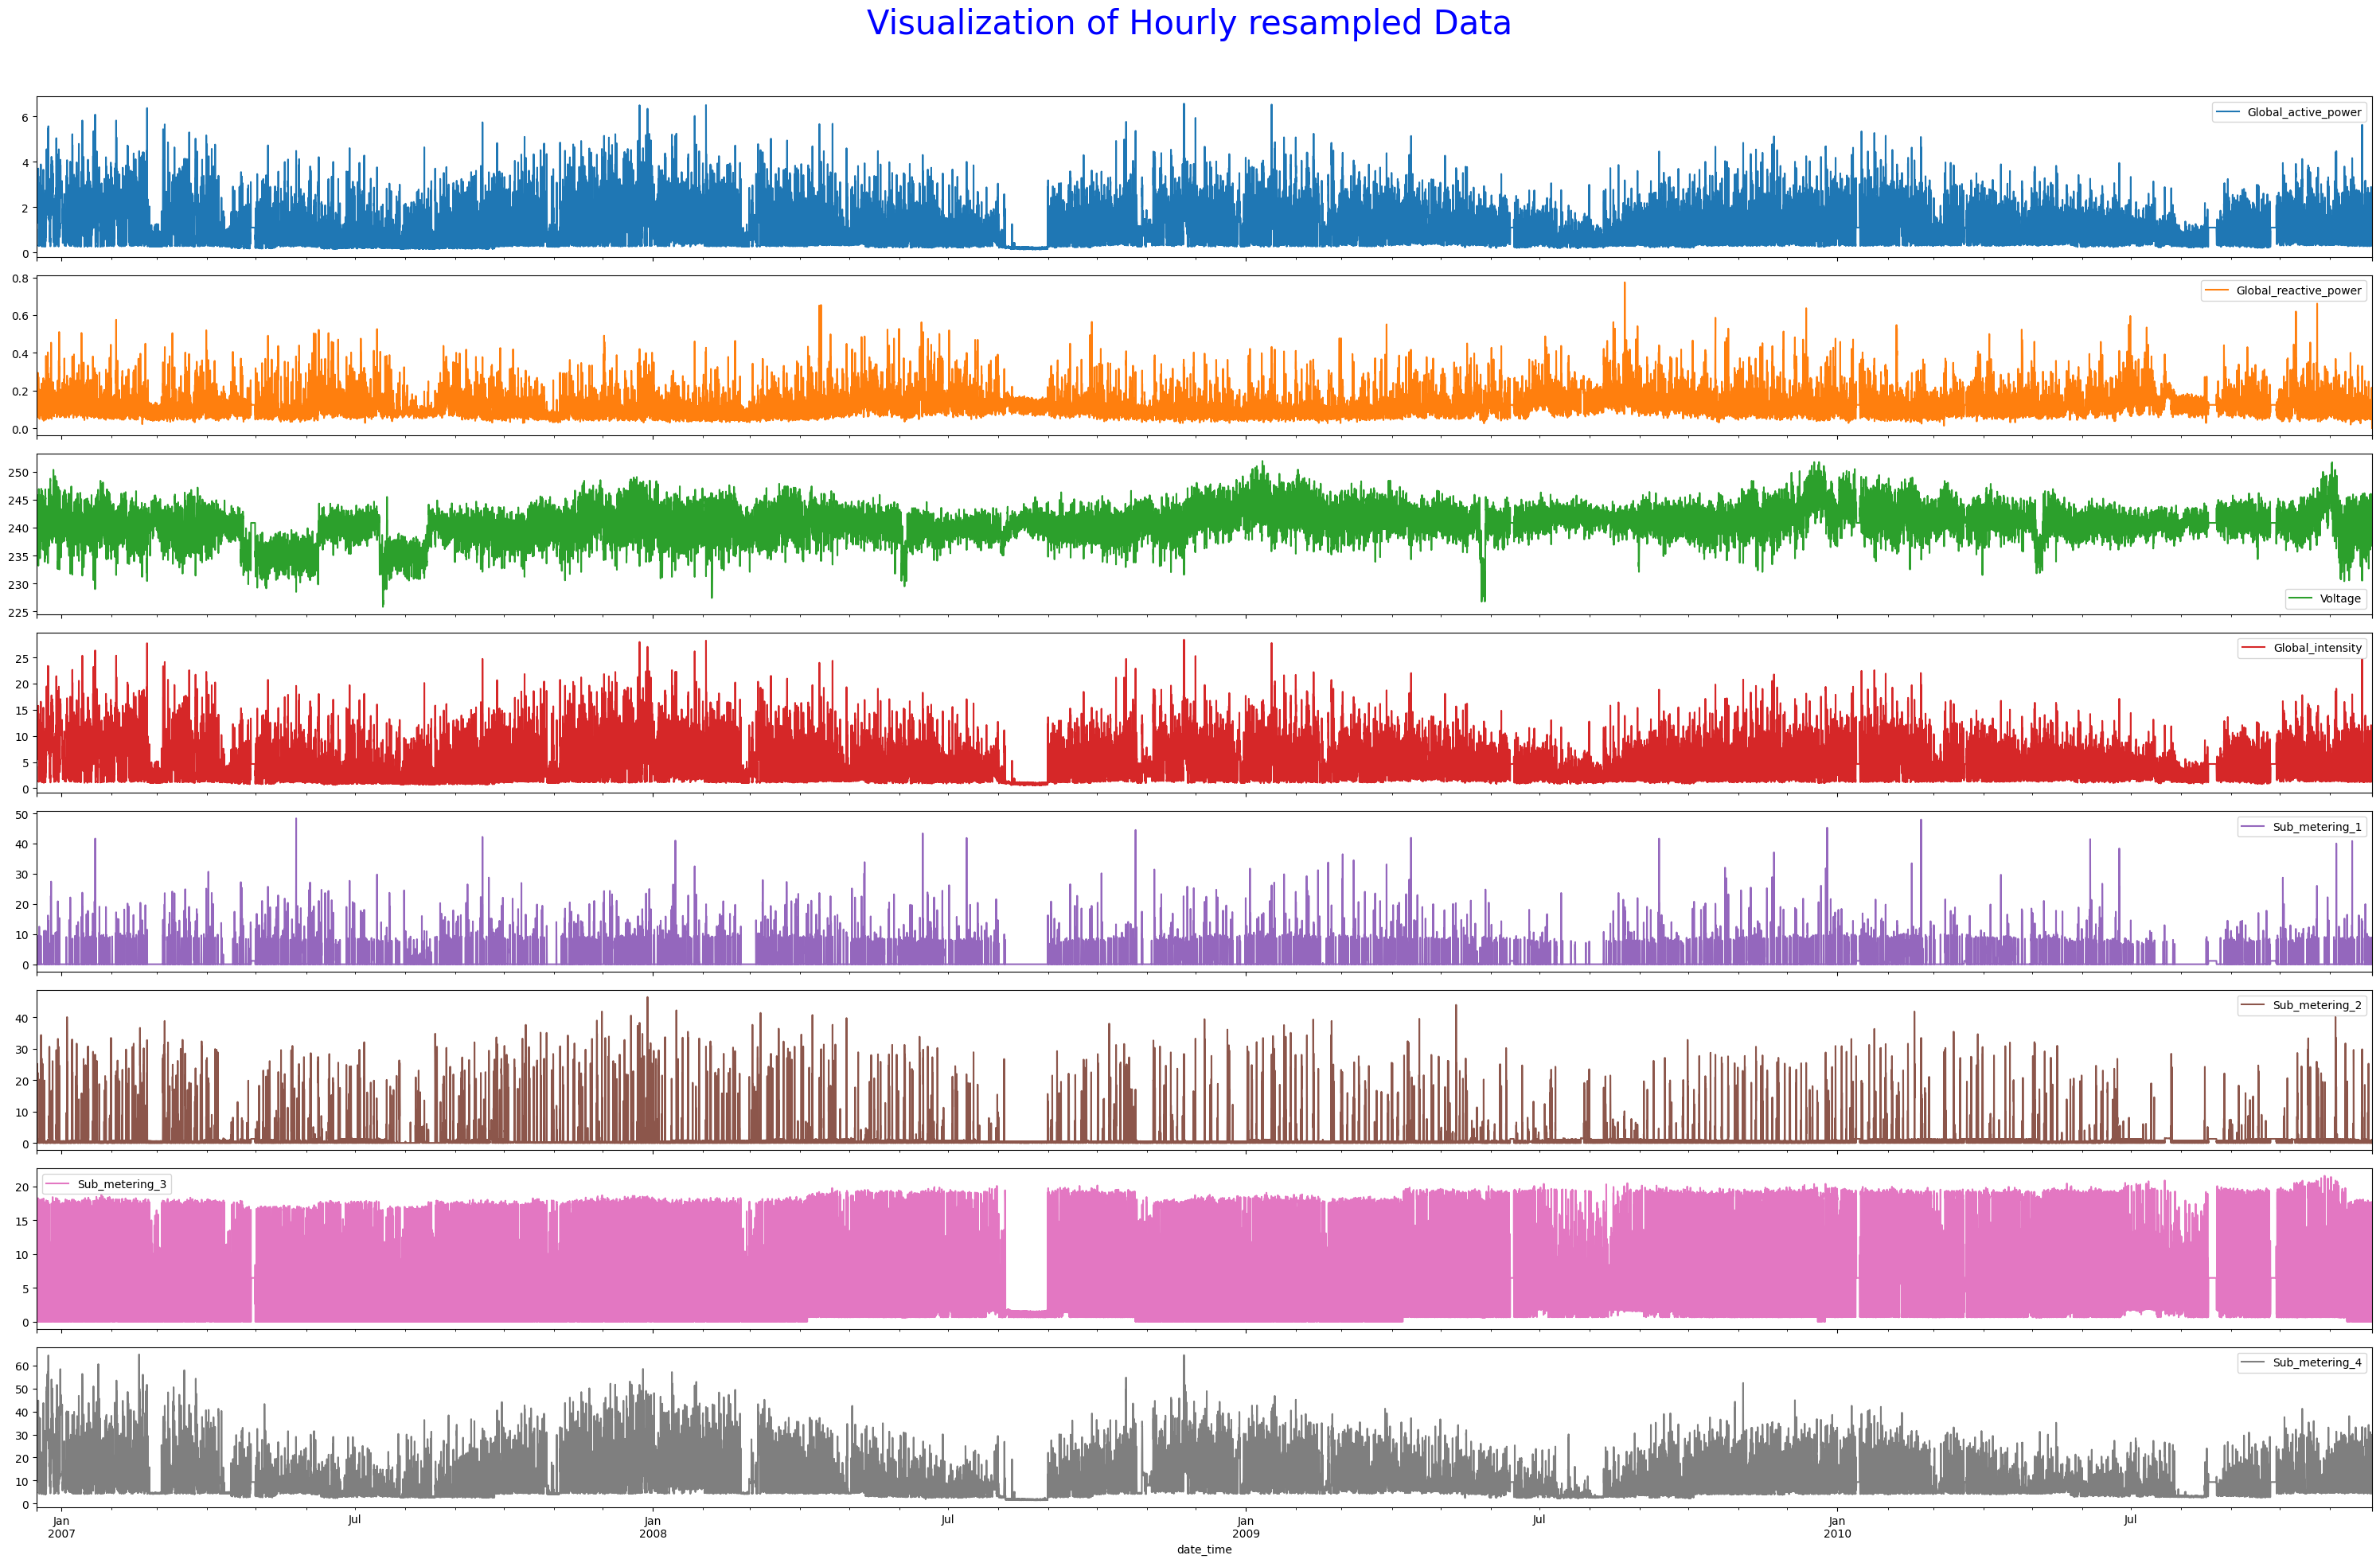

 

************************************************ Hourly Resampled distribution Plot **************************************************



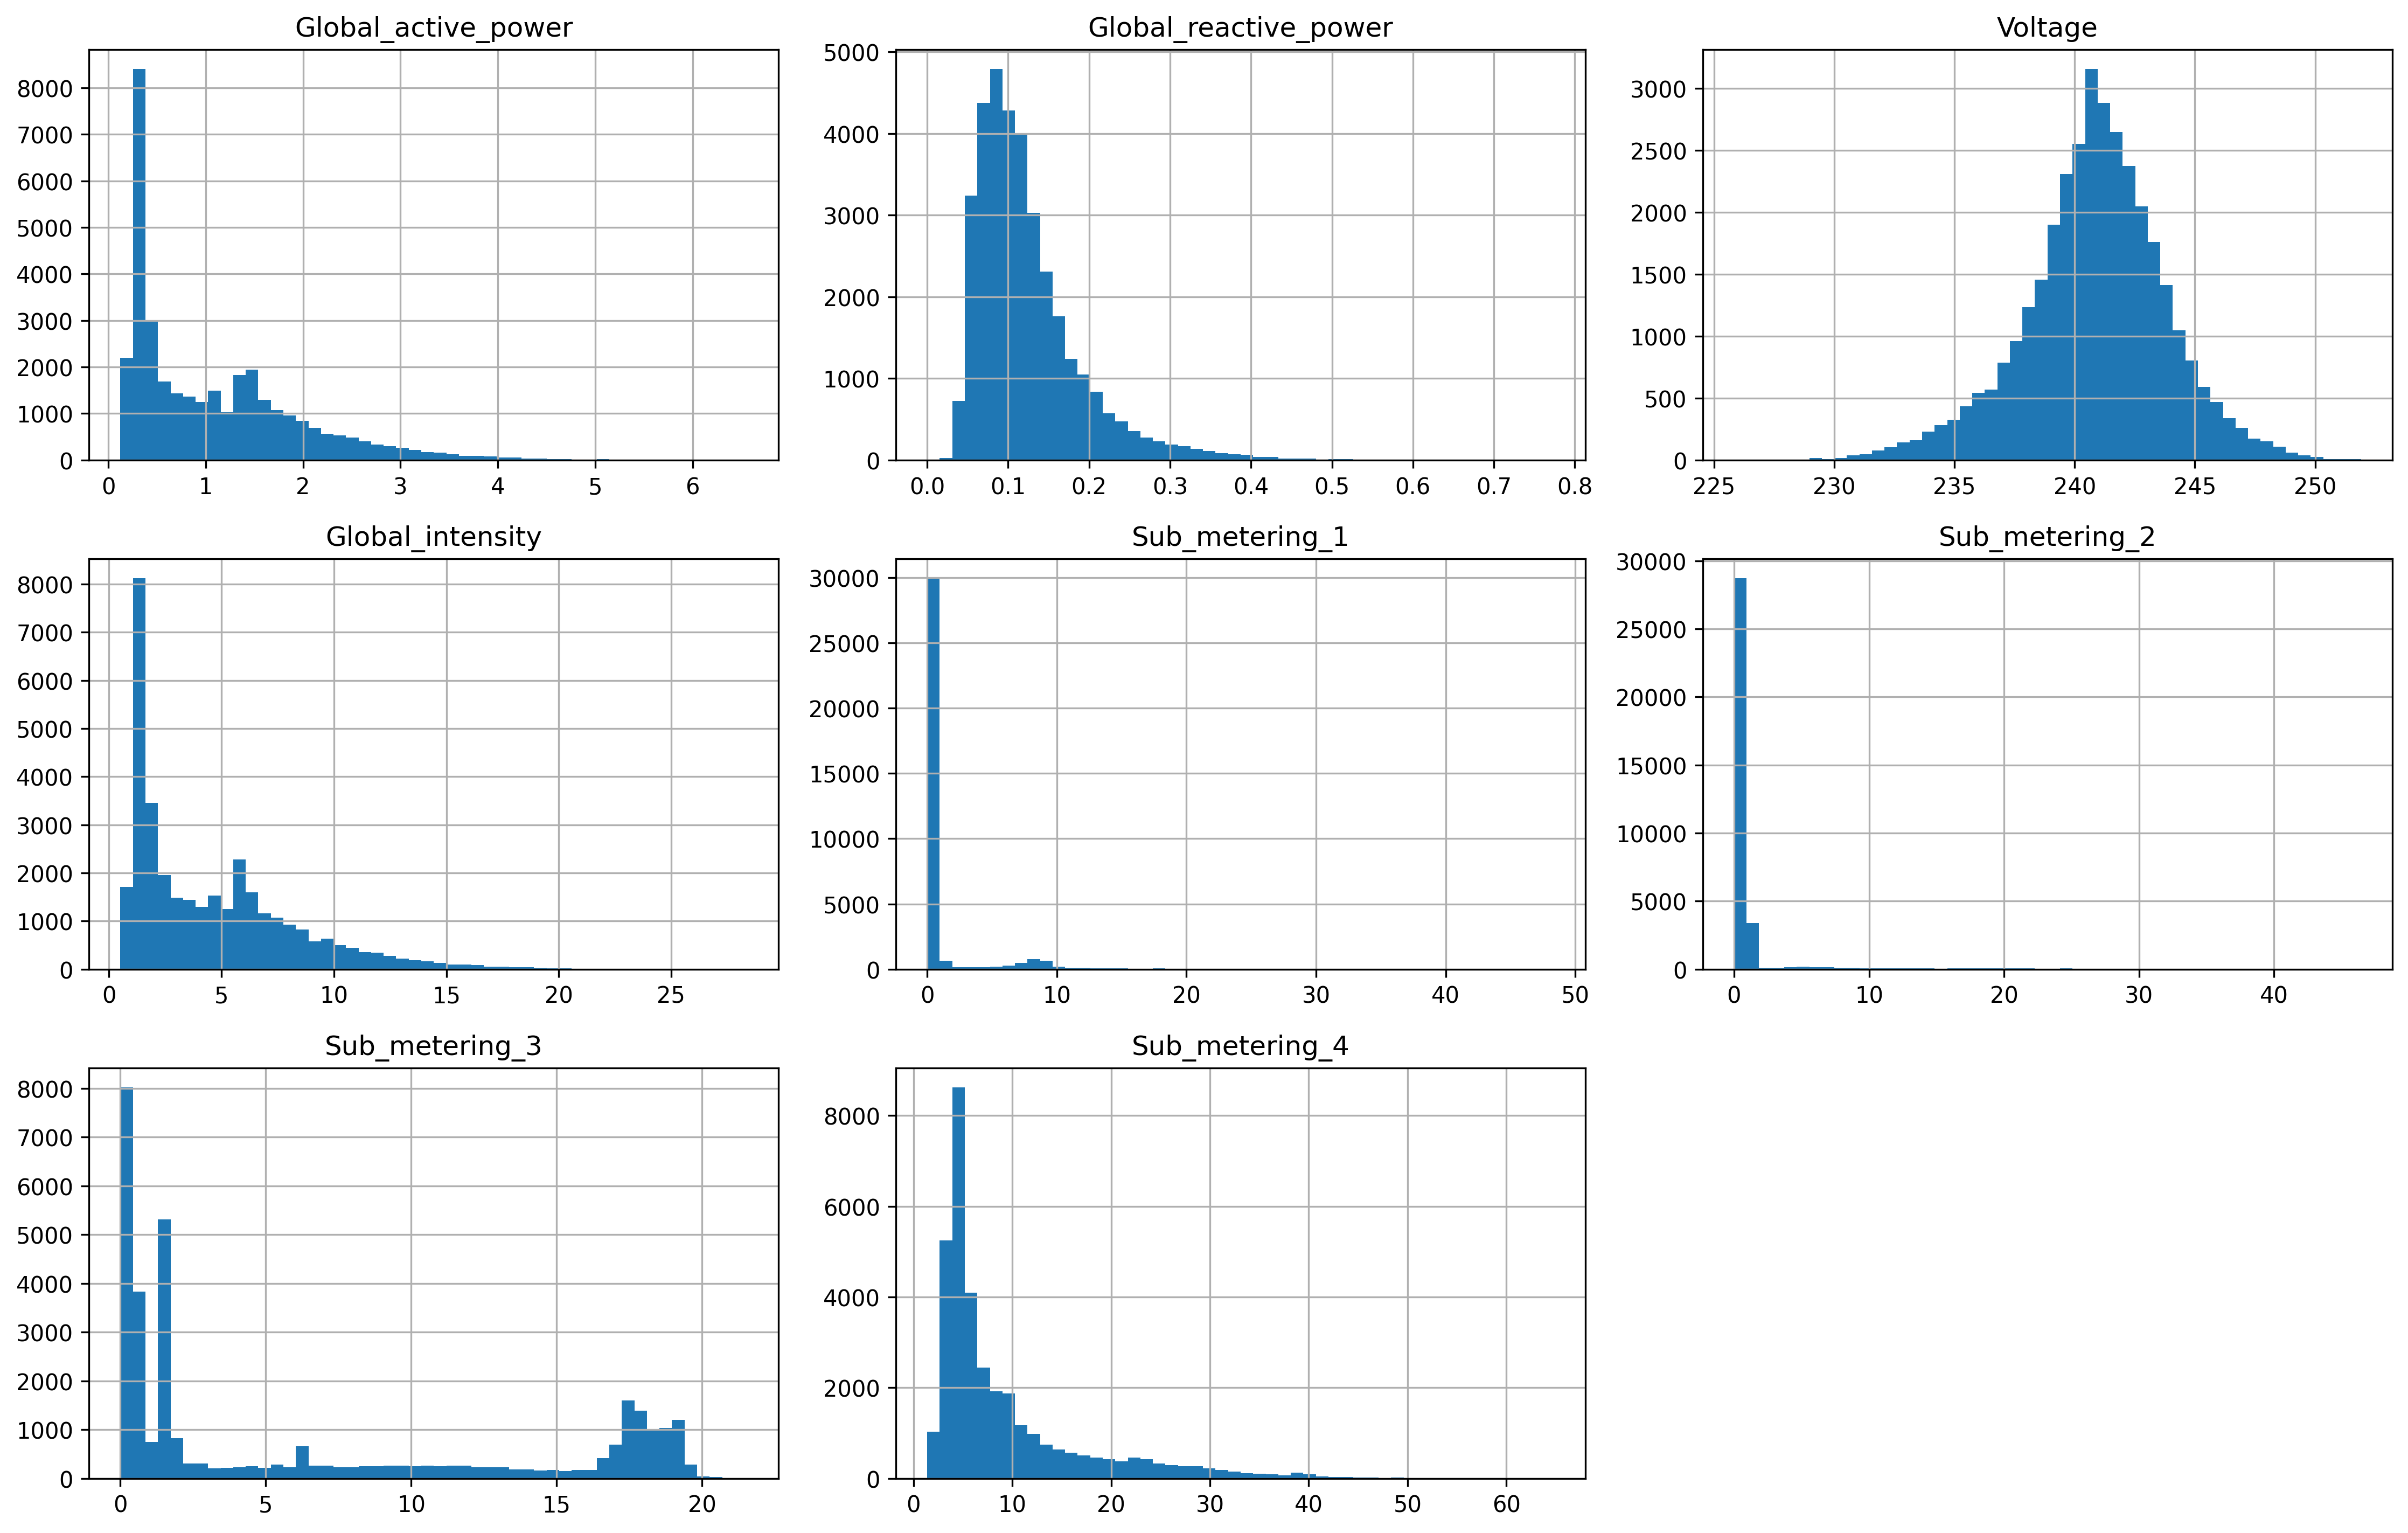

 

************************************************ Hourly Resampled correlation Plot **************************************************



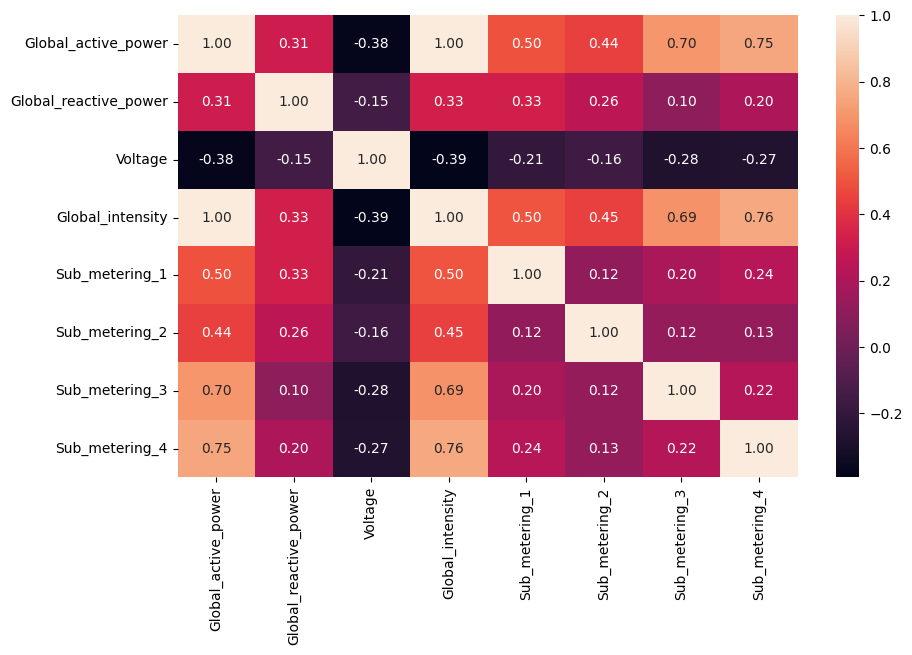

In [ ]:
# Plot the visualization, distribution and correlation of Hourly resampled data
df_visu_dist_corr(df, "H", "Hourly")

Note:- As Global_intensity and Sub_metering_4 are highly correlated with Global_active_power so I am removing Global_intensity column

In [ ]:
hourly_resampled = df.resample('H').mean()

In [ ]:
# Transform the Global_active_power column of the data DataFrame into a numpy array of float values
df1 = hourly_resampled.Global_active_power.values.astype('float32')

# Reshape the numpy array into a 2D array with 1 column
df1 = np.reshape(df1, (-1, 1))

# Create an instance of the MinMaxScaler class to scale the values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [ ]:
df1.shape

(34589, 1)

# Train-Test Splitting

In [ ]:
# Split the transformed data into a training set (80%) and a test set (20%)

train_size = int(len(df1) * 0.80)
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1),:]

In [ ]:
train.shape

(27671, 1)

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
X_train.shape, Y_train.shape

((27640, 30), (27640,))

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((27640, 1, 30), (27640,), (6887, 1, 30), (6887,))

# LSTM model

In [ ]:
# Create the LSTM model
model = Sequential()

# Add LSTM layers with dropout
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Add a dense output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Displaying a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            81408     
                                                                 
 dropout_3 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [ ]:
# Fitting the model on training data and using early stopping to avoid overfitting
history = model.fit(X_train, Y_train, epochs=20, batch_size=1240, validation_data=(X_test, Y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=4)], verbose=1, shuffle=False)

Epoch 1/20
23/23 [==============================] - 8s 95ms/step - loss: 0.0314 - val_loss: 0.0116
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0188 - val_loss: 0.0107
Epoch 3/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0162 - val_loss: 0.0090
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0133 - val_loss: 0.0077
Epoch 5/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0120 - val_loss: 0.0073
Epoch 6/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0112 - val_loss: 0.0069
Epoch 7/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0106 - val_loss: 0.0067
Epoch 8/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0066
Epoch 9/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0064
Epoch 10/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0064
Epoch 11/20
23/23 

# Evaluation of model

In [ ]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert transform
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

216/216 [==============================] - 1s 3ms/step
Train Mean Absolute Error: 0.4162559607863142
Train Root Mean Squared Error: 0.5980868363038
Test Mean Absolute Error: 0.3560591288600428
Test Root Mean Squared Error: 0.5048671595648833


In [ ]:
# Calculate evaluation metrics
print('Train Mean Absolute Error (MAE):', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Mean Squared Error (MSE):', mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error (RMSE):',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))

print('\nTest Mean Absolute Error (MAE):', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Mean Squared Error (MSE):', mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error (RMSE):',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error (MAE): 0.4162559607863142
Train Mean Squared Error (MSE): 0.3577078637598884
Train Root Mean Squared Error (RMSE): 0.5980868363038

Test Mean Absolute Error (MAE): 0.3560591288600428
Test Mean Squared Error (MSE): 0.2548908488071133
Test Root Mean Squared Error (RMSE): 0.5048671595648833


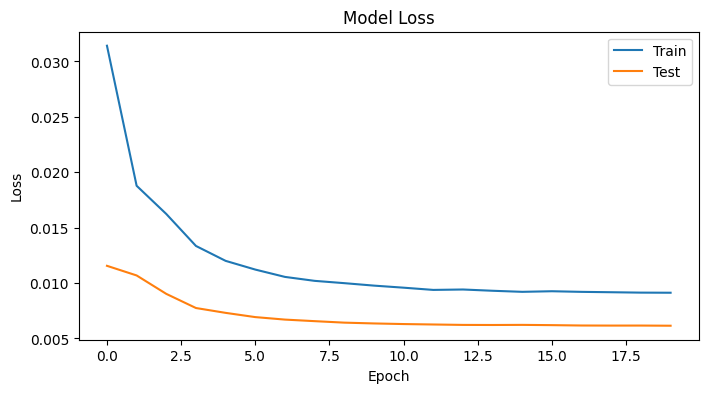

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

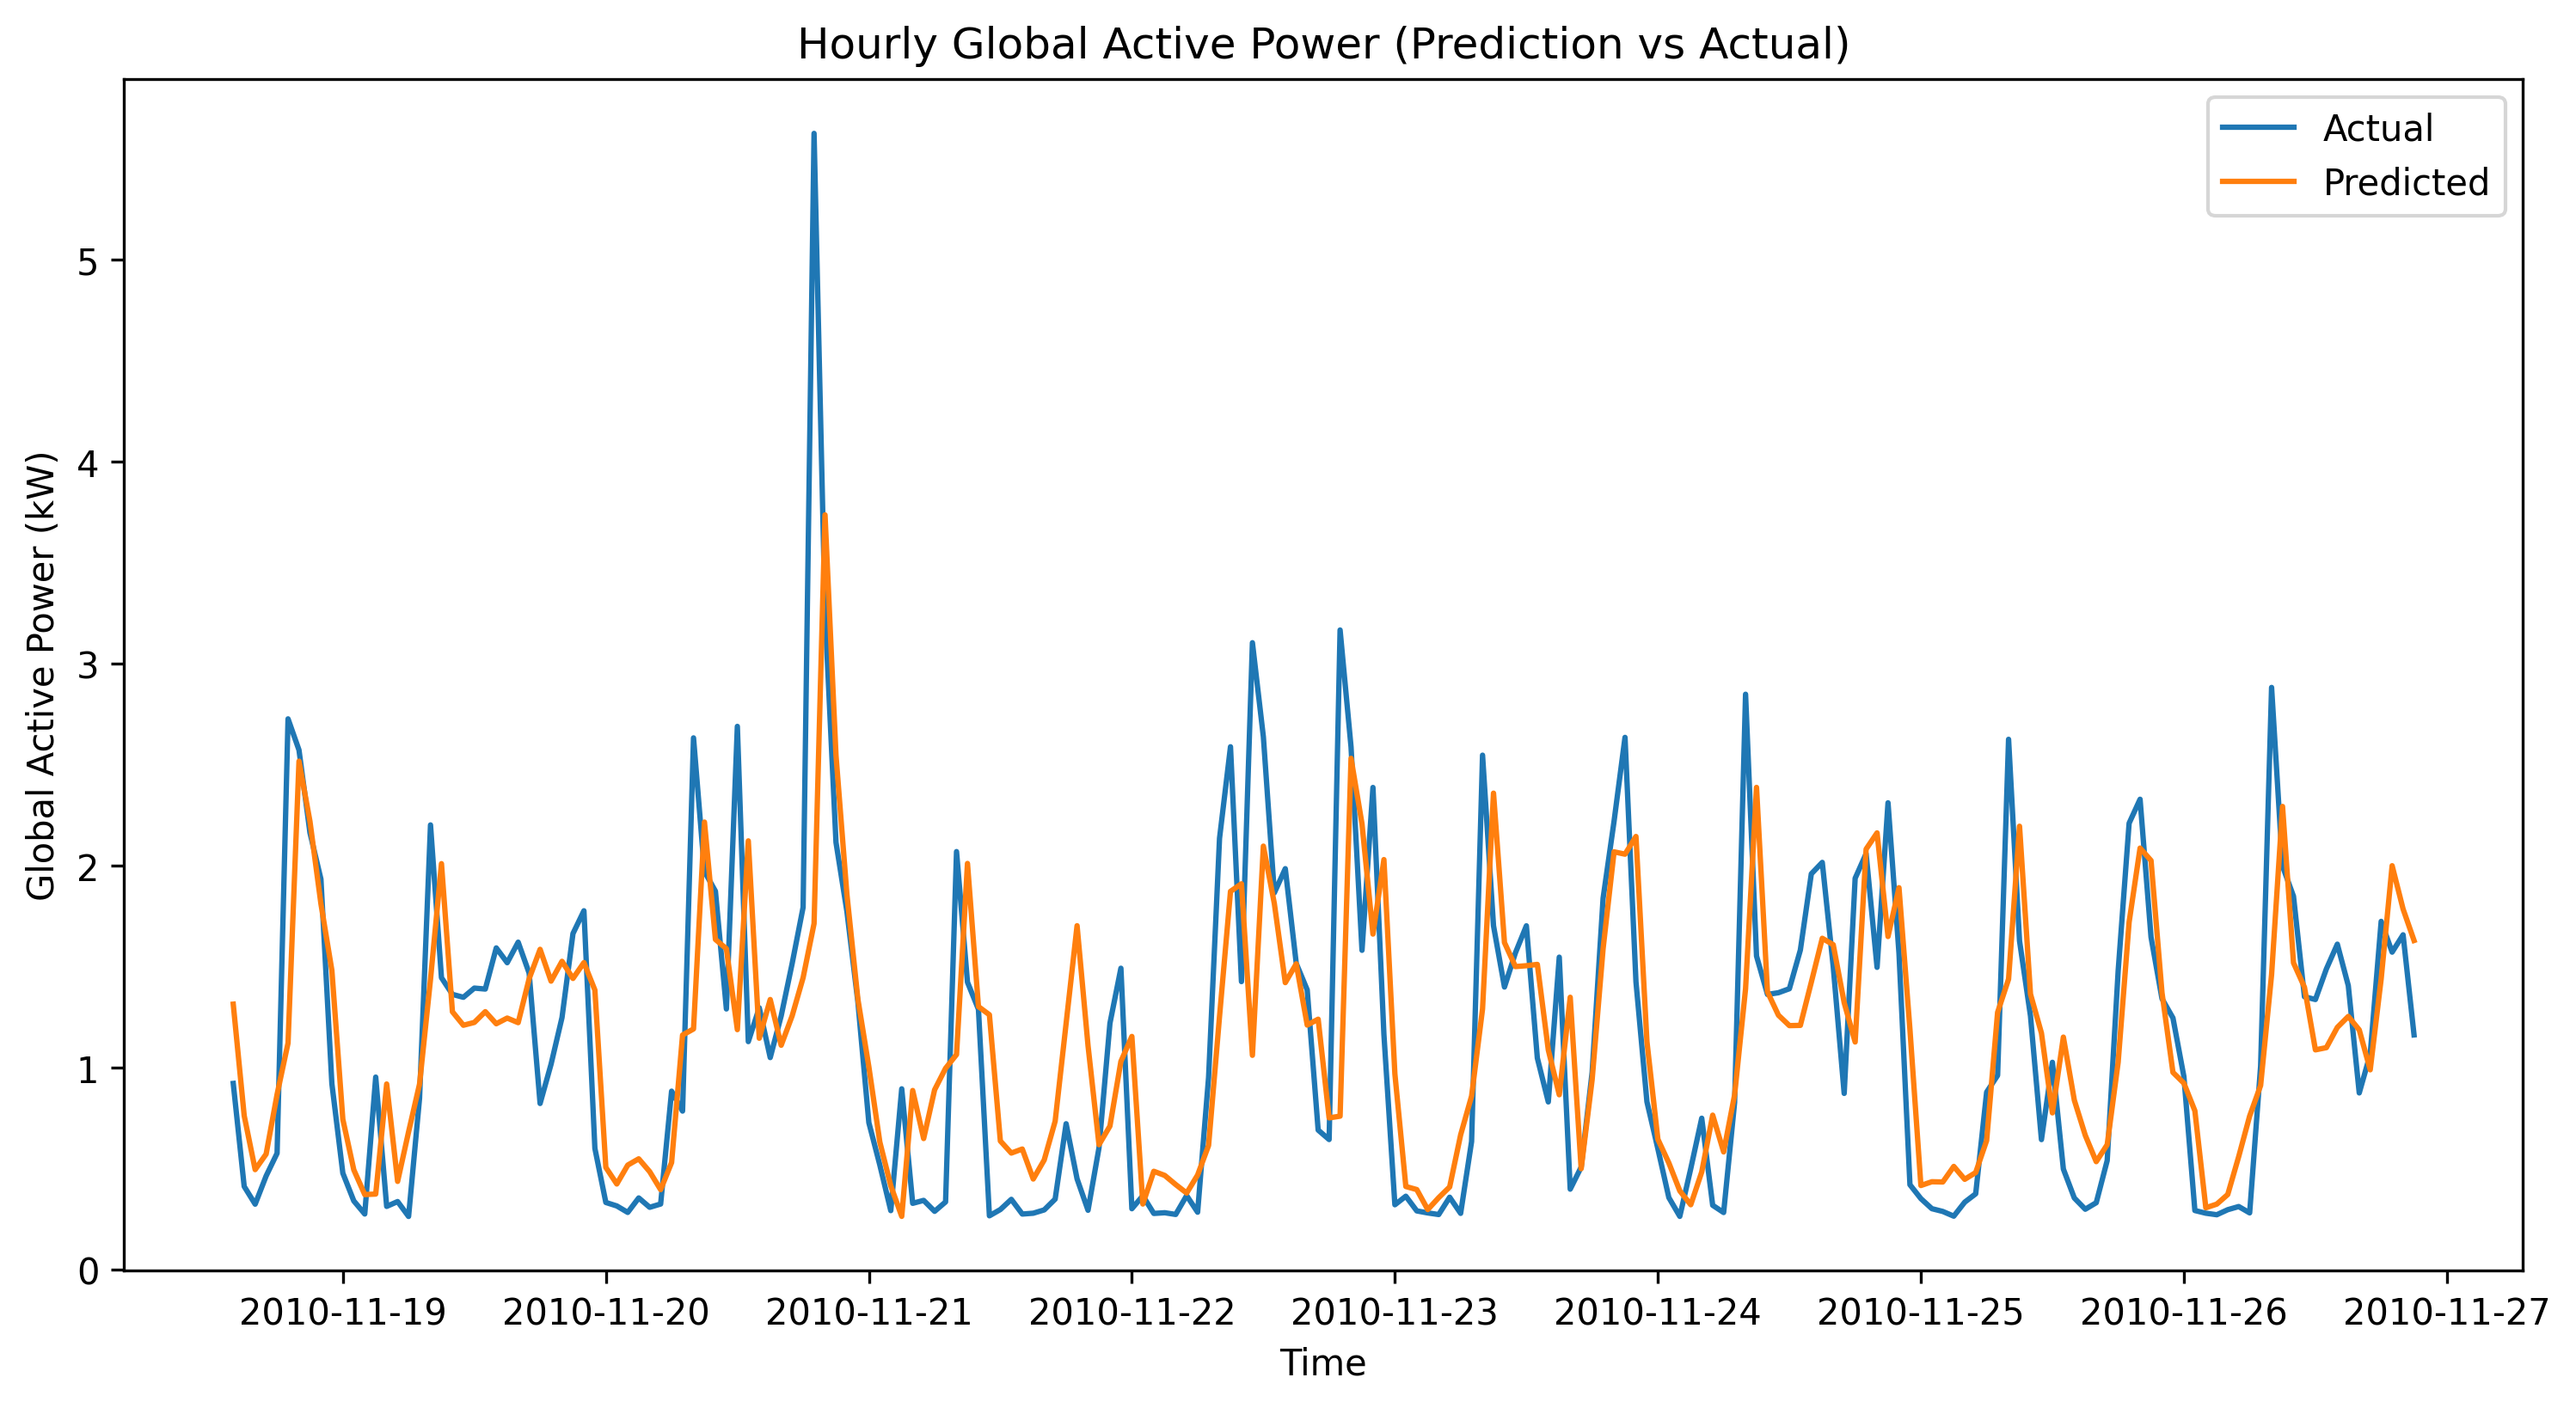

In [ ]:
# Plotting predicted and actual temperatures
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(hourly_resampled.index[-200:], Y_test[0][-200:], label='Actual')
plt.plot(hourly_resampled.index[-200:], test_predict[:,0][-200:], label='Predicted')
plt.title('Hourly Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()